# Demo - Detecção de anomalias nos dados do CMS

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn.externals.six import StringIO  
import pydot
import random
import sys
from sklearn.cross_validation import cross_val_score
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from IPython.display import Image
from scipy.stats import skew, kurtosis

## Carregamento dos dados

* PRESCRIBER_NPI_DRUG.tab -- dados de prescrições médicas da agência federal americana CMS
    - NPI – Provider's ID.
    - drug_name – The name of the drug filled. 
    - specialty_description – Derived from the Medicare provider/supplier specialty code.
    - total_claim_count – The number of Medicare Part D claims. This includes original prescriptions and refills. 
    - total_day_supply – The aggregate number of day’s supply for which this drug was dispensed.
    - total_drug_cost – The aggregate total drug cost paid for all associated claims.
  
* LEIE_EXCLUSIONS.csv -- dados profissionais de saúde que foram excluídos da CMS por fraude e outros problemas

In [2]:
# Dados de prescrições médicas 
data_raw = pd.read_csv('../data/PRESCRIBER_NPI_DRUG.tab', sep='\t')
    
# Profissionais de saúde que cometeram algum tipo de fraude
anomalies = pd.read_csv('../data/LEIE_EXCLUSIONS.csv', low_memory = False)

## Análise exploratória

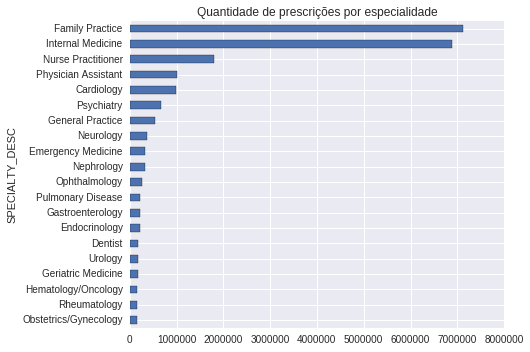

In [5]:
plt.figure()
d = data_raw.groupby('SPECIALTY_DESC').count()['NPI']
d.sort_values().tail(20).plot(kind='barh', title=u'Quantidade de prescrições por especialidade')
plt.gcf().subplots_adjust(left=0.25)

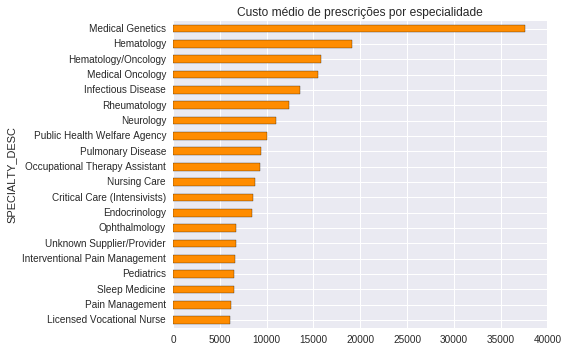

In [6]:
plt.figure()
d = data_raw.groupby('SPECIALTY_DESC').mean()['TOTAL_DRUG_COST']
d.sort_values().tail(20).plot(kind='barh', title=u'Custo médio de prescrições por especialidade', color ='DarkOrange')
plt.gcf().subplots_adjust(left=0.25)

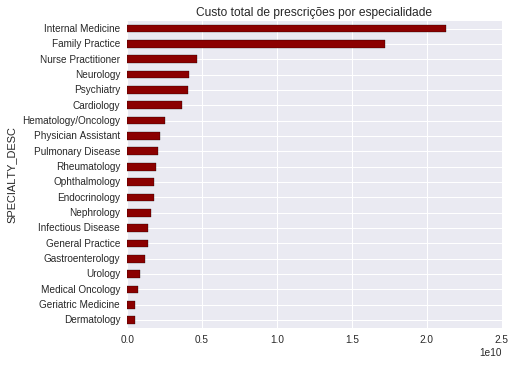

In [7]:
plt.figure()
d = data_raw.groupby('SPECIALTY_DESC').sum()['TOTAL_DRUG_COST']
d.sort_values().tail(20).plot(kind='barh', title=u'Custo total de prescrições por especialidade', color = 'DarkRed')
plt.gcf().subplots_adjust(left=0.25)

### Dados de exclusão / anomalia

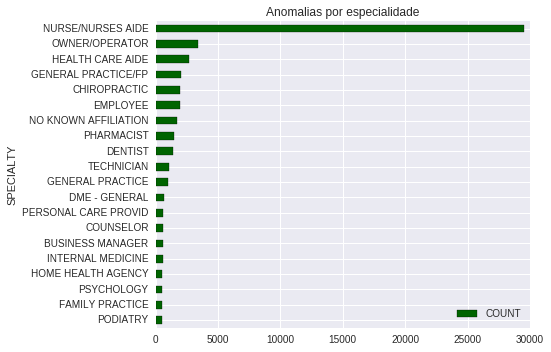

In [8]:
specialty_anomalies = anomalies[["SPECIALTY"]]
specialty_anomalies["COUNT"] = 1
specialty_anomalies = specialty_anomalies.groupby("SPECIALTY").agg("count")

plt.figure()
specialty_anomalies.sort_values("COUNT").tail(20).plot(kind='barh', title=u'Anomalias por especialidade', color = 'DarkGreen')
plt.gcf().subplots_adjust(left=0.25)

In [9]:
states = anomalies[["STATE"]]
states["COUNT"] = 1
states_anomalies = states.groupby("STATE").agg("count")
states_anomalies_dict = states_anomalies.to_dict()['COUNT']
states_dict = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}
popdensity = dict((states_dict[key], value) for (key,value) in states_anomalies_dict.items() if key in states_dict)

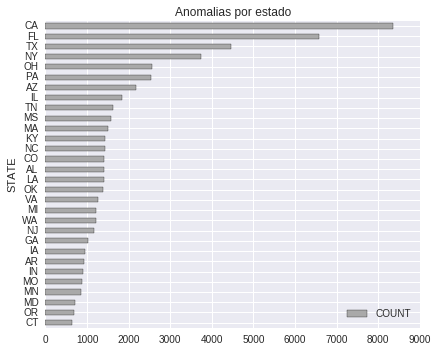

In [10]:
plt.figure()
states_anomalies.sort_values("COUNT").tail(30).plot(kind='barh', title=u'Anomalias por estado', color = 'DarkGrey')
plt.gcf().subplots_adjust(left=0.25)

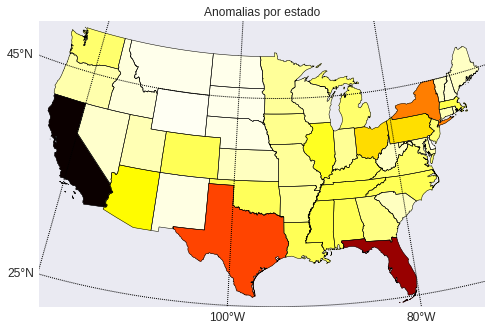

In [11]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# Data from U.S Census Bureau http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

# Choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = float(min(popdensity.values()))
vmax = float(max(popdensity.values()))

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = popdensity[statename]
        colors[statename] = cmap(1.-((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
# Cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
# Draw meridians and parallels.
m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
plt.title('Anomalias por estado')
plt.show()

## Pré-processamento dos dados

In [12]:
num_cols = ['NPI', 'TOTAL_CLAIM_COUNT', 'TOTAL_DAY_SUPPLY', 'TOTAL_DRUG_COST', 'SPECIALTY_DESC', 'GENERIC_NAME']
data_raw = data_raw[num_cols]
data_raw['ANOMALY'] = 0
data_raw.loc[data_raw.NPI.isin(set(anomalies[['NPI']].values[:, 0])), 'ANOMALY'] = 1

## Engenharia de características

In [ ]:
def gt_mean(group):
    mean = group.mean()
    std = group.std()
    return (group.values > (mean + 4*std)).sum()

def contains(sub):
    return lambda x: any(x.str.contains(sub))

data = data_raw.groupby('NPI').agg({
    'TOTAL_CLAIM_COUNT': ['count', np.sum, np.mean, np.std, np.max, np.min],
    'TOTAL_DAY_SUPPLY': ['count', np.sum, np.mean, np.std, np.max, np.min],
    'TOTAL_DRUG_COST': ['count', np.sum, np.mean, np.std, np.max, np.min],
    'ANOMALY': np.sum,
    'SPECIALTY_DESC' : {"Nurse": contains("Nurse"), "Pract": contains("Pract")},
    'GENERIC_NAME': {"Sert": contains("SERTRALINE"), "HCL": contains("HCL")}
}).fillna(0)

labels = ['Claim Count', 'Claim Sum', 'Claim Mean','Claim Std','Claim Max','Claim Min',
          'Day Supply Count', 'Day Supply Sum', 'Day Supply Mean','Day Supply Std','Day Supply Max','Day Supply Min',
          'Drug Cost Count', 'Drug Cost Sum', 'Drug Cost Mean','Drug Cost Std','Drug Cost Max','Drug Cost Min',
          'Nurse', 'Practioner','Sertraline','HCL']

In [77]:
X_data = data[['TOTAL_CLAIM_COUNT', 'TOTAL_DAY_SUPPLY', 'TOTAL_DRUG_COST', 'SPECIALTY_DESC', 'GENERIC_NAME']].astype(float).values
y_data = data[['ANOMALY']].values[:, 0] > 0

idxs = list(range(X_data.shape[0]))
random.seed(0)
random.shuffle(idxs)
idxs_train = idxs[:int(len(idxs)*0.7)]
idxs_test = idxs[int(len(idxs)*0.7):]

means = X_data[idxs_train].mean(axis=0)
stds = X_data[idxs_train].std(axis=0)
stds[stds == 0] = 1.0
X_data = (X_data - means)/stds

X_train = X_data[idxs_train]
y_train = y_data[idxs_train]

X_test = X_data[idxs_test]
y_test = y_data[idxs_test]

print(u'Quantidade de profissionais de saúde: {0}'.format(y_data.shape[0]))
print(u'Quantidade de fraudes: {0} ({1:0.4f}%)'.format(y_data.sum(), 100*y_data.sum()/float(y_data.shape[0])))

Quantidade de profissionais de saúde: 808020
Quantidade de fraudes: 589 (0.0729%)


## Treinamento dos algoritmos

In [79]:
lr = linear_model.LogisticRegression(C = 0.001668, class_weight='balanced', random_state = 0)
lr.fit(X_train, y_train)

LogisticRegression(C=0.001668, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [80]:
rf = ensemble.RandomForestClassifier(n_estimators = 2000, class_weight='balanced', max_depth = 4, n_jobs=10, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=10,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
dt = tree.DecisionTreeClassifier(class_weight='balanced', max_depth = 5, random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

## Avalição e visualização dos resultados

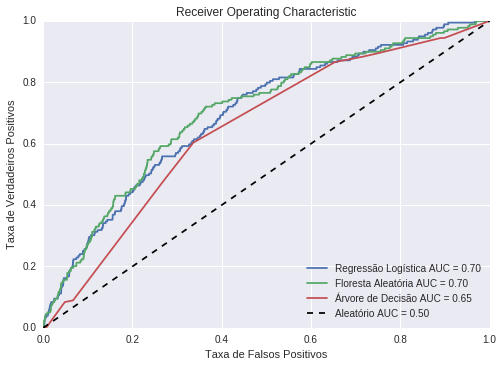

In [66]:
plt.figure()

def plot_roc_auc(clf, label, test = True):
    if test:
        ts = y_test
        ps = clf.predict_proba(X_test)[:, 1]
    else:
        ts = y_train
        ps = clf.predict_proba(X_train)[:, 1]
        label = "Train " + label
    roc_auc = metrics.roc_auc_score(y_true=ts, y_score=ps)
    fpr, tpr, _ = metrics.roc_curve(y_true=ts, y_score=ps)
    plt.plot(fpr, tpr, label=label + ' AUC = %0.2f' % roc_auc)

plot_roc_auc(lr, u'Regressão Logística')
plot_roc_auc(rf, u'Floresta Aleatória')
plot_roc_auc(dt, u'Árvore de Decisão')

plt.plot([0,1], [0,1], 'r--', color='black', label=u'Aleatório AUC = 0.50')

plt.title('Receiver Operating Characteristic')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.legend(loc='lower right')
plt.show()

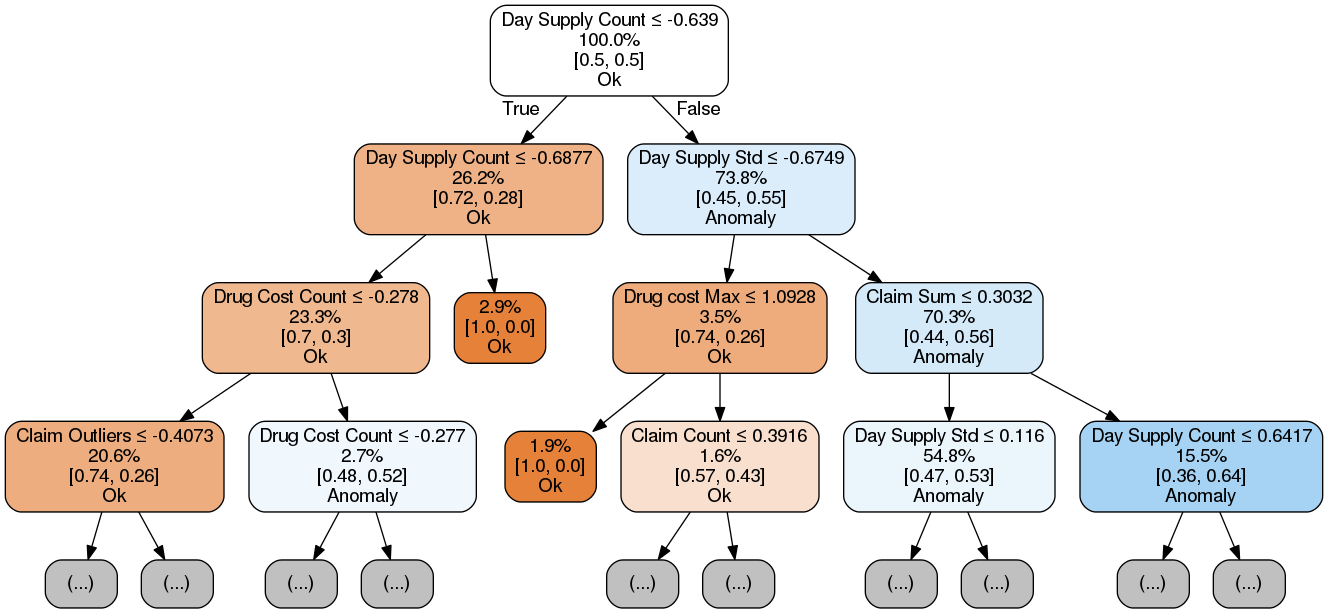

In [78]:
if (sys.version_info < (3, 0)):
    dot_data = StringIO()
    tree.export_graphviz(dt, out_file=dot_data,
                    feature_names = labels, class_names=['Ok', 'Anomaly'],  
                    filled=True, rounded=True, max_depth = 3,
                    special_characters=True, label = True,
                    impurity = False, proportion = True)  
    dot_data.seek(0)
    a = dot_data.getvalue()
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    with open("dt.png", "wb") as f:
        f.write(graph.create_png())
Image("dt.png")

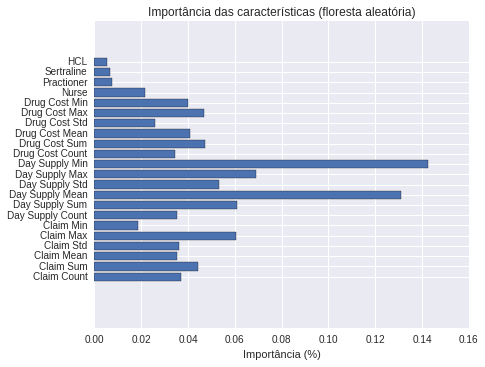

In [70]:
importances = rf.feature_importances_
pos = np.arange(len(labels))
plt.figure()
plt.barh(pos,importances,  align='center')
plt.yticks(pos, labels)
plt.xlabel(u'Importância (%)')
plt.title(u'Importância das características (floresta aleatória)')
plt.gcf().subplots_adjust(left=0.25)
plt.show()

In [84]:
ts = y_test
ps = lr.predict_proba(X_test)[:, 1]
fpr, tpr, t = metrics.roc_curve(y_true=ts, y_score=ps)
y_pred = lr.predict_proba(X_test)[:, 1]>t[np.argmax(fpr>0.1)]
mask = (y_test & y_pred)
total_cost = X_test[mask, 13]*stds[13]+means[13]
print(u'Profissionais de saúde no total:', len(ts))
print(u'Profissionais apontados para avaliação:', y_pred.sum())
print(u'Profissionais anômalos detectados:', mask.sum())
print(u'Quantia de dólares em fraudes detectadas: $ {0:.2f}'.format(total_cost.sum()))

Profissionais de saúde no total: 242406
Profissionais apontados para avaliação: 24593
Profissionais anômalos detectados: 50
Quantia de dólares em fraudes detectadas: $ 25485427.00
